In [1]:
import cv2
import numpy as np
import dlib
from matplotlib import pyplot as plt

In [10]:
cap = cv2.VideoCapture(0)

# capture one frame and conver to gray scale
ret, frame = cap.read()
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# release the capture handle
cap.release()

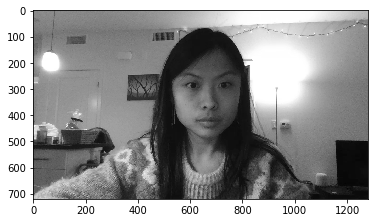

In [11]:
plt.imshow(gray, cmap='gray', vmin=0, vmax=255)
plt.show()

In [12]:
gray.shape

(720, 1280)

In [13]:
# front face detector
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("../data/support/shape_predictor_68_face_landmarks.dat")
faces = detector(gray)

In [14]:
len(faces)

1

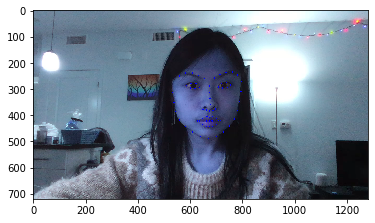

In [15]:
for f in faces:
    shape = predictor(gray, f)
    for i in range(1,68): #There are 68 landmark points on each face
        cv2.circle(frame, (shape.part(i).x, shape.part(i).y), 1, (0,0,255), thickness=2)
    plt.imshow(frame)

In [16]:
# extract the coordinates of landmarks
face1 = faces[0]

In [17]:
shape = predictor(gray, face1)
landmarks = np.asarray([(shape.part(i).x, shape.part(i).y) for i in range(68)])